Pixel wise segmentation using RNN's

In [2]:
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import numpy as np

from tensorflow.keras.metrics import MeanIoU

import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import PIL
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
np.random.seed(101)
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.optimizers import Adam, SGD
import random
from tensorflow.keras.metrics import MeanIoU
import os
from tensorflow.keras.optimizers import Adam
from keras import backend, optimizers
from keras.layers import concatenate
from sklearn.metrics import roc_curve, auc
from PIL import Image
import re
from sklearn.metrics import ConfusionMatrixDisplay,f1_score
from sklearn.metrics import confusion_matrix

In [3]:
 !git clone https://github.com/Shankar0x/Datasets.git imgs

Cloning into 'imgs'...
Updating files:   6% (672/9861)
Updating files:   7% (691/9861)
Updating files:   8% (789/9861)
Updating files:   9% (888/9861)
Updating files:  10% (987/9861)
Updating files:  11% (1085/9861)
Updating files:  12% (1184/9861)
Updating files:  13% (1282/9861)
Updating files:  13% (1297/9861)
Updating files:  14% (1381/9861)
Updating files:  15% (1480/9861)
Updating files:  16% (1578/9861)
Updating files:  17% (1677/9861)
Updating files:  18% (1775/9861)
Updating files:  19% (1874/9861)
Updating files:  19% (1900/9861)
Updating files:  20% (1973/9861)
Updating files:  21% (2071/9861)
Updating files:  22% (2170/9861)
Updating files:  23% (2269/9861)
Updating files:  24% (2367/9861)
Updating files:  25% (2466/9861)
Updating files:  26% (2564/9861)
Updating files:  27% (2663/9861)
Updating files:  27% (2712/9861)
Updating files:  28% (2762/9861)
Updating files:  29% (2860/9861)
Updating files:  30% (2959/9861)
Updating files:  31% (3057/9861)
Updating files:  32% (315

In [3]:
image_files_trainx = [os.path.join('imgs/Skin_Lesion_Dataset/trainx', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/trainx')]
image_files_trainy = [os.path.join('imgs/Skin_Lesion_Dataset/trainy', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/trainy')]

image_files_testx = [os.path.join('imgs/Skin_Lesion_Dataset/testx', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/testx')]
image_files_testy = [os.path.join('imgs/Skin_Lesion_Dataset/testy', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/testy')]

trainx = []
trainy = []

testx = []
testy = []

# Image is being resized to a small image to make training faster.

IMAGE_DIM = 32
NUM_TRAIN_IMAGES = 500

i = 0
for path in image_files_trainx:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM)) / 255.0
  trainx.append(img)
  
  if i > NUM_TRAIN_IMAGES:
    break


i = 0
for path in image_files_trainy:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM))

  condition = tf.reduce_all(img > 125, axis=-1)

  img  = tf.where(condition, 1, 0)
  trainy.append(img)

  if i > NUM_TRAIN_IMAGES:
    break
   
for path in image_files_testx:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM)) / 255.0
  testx.append(img)

for path in image_files_testy:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM))
  condition = tf.reduce_all(img > 125, axis=-1)

  img  = tf.where(condition, 1, 0)
  testy.append(img)

trainx = np.array(trainx)
trainy = np.array(trainy)

testx = np.array(testx)
testy = np.array(testy)

image_shape_input = trainx[0].shape
image_shape_output = trainy[0].shape

In [4]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(trainx,trainy,test_size=0.25,random_state=101)

In [5]:
print(trainy.shape)
print(trainx.shape)

(2000, 32, 32)
(2000, 32, 32, 3)


In [6]:
print('image shape input : ', image_shape_input)
print('image shape output : ', image_shape_output)

image shape input :  (32, 32, 3)
image shape output :  (32, 32)


trainx


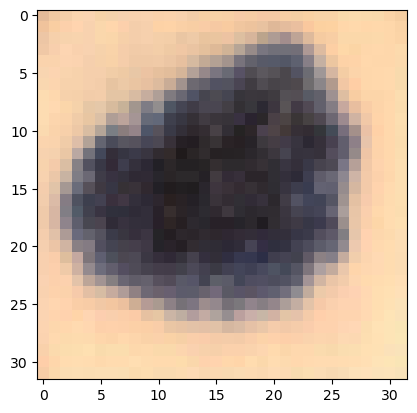

trainy


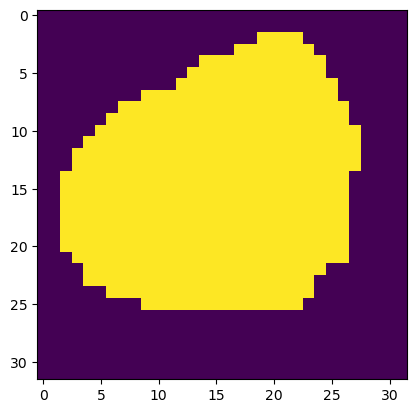

testx


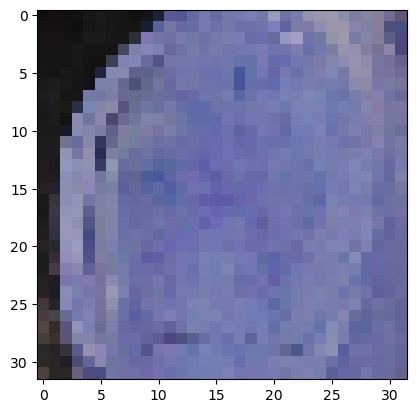

testy


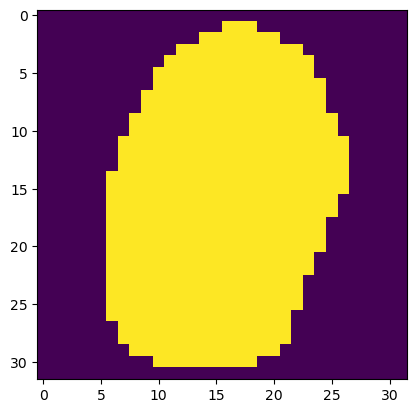

array([0, 1])

In [7]:
# Print image from each of these foldes
print('trainx')
plt.imshow(trainx[0])
plt.show()

print('trainy')
plt.imshow(trainy[0])
plt.show()

print('testx')
plt.imshow(testx[0])
plt.show()

print('testy')
plt.imshow(testy[0])
plt.show()

np.unique(trainy[0])

Defining the Model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 1, 3)),
    tf.keras.layers.Reshape((1, 3)),  
    # Replace Conv2D layers with LSTM layer (which was present in the first pixel-wise CNN segmentation model)
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))
])

model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 3)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             17408     
                                                                 
 time_distributed (TimeDistr  (None, 1, 1)             65        
 ibuted)                                                         
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Reshape entire trainx and trainy into array where each elem is 1x1x3
trainx_flat = trainx.reshape(-1, 1, 1, 3)
print('overall trainx shape : ', trainx_flat.shape)
print('shape of each image : ', trainx_flat[0].shape)

trainy_flat = trainy.reshape(-1, 1, 1, 1)

x_val_flat = x_val.reshape(-1, 1, 1, 3)
y_val_flat = y_val.reshape(-1, 1, 1, 1)

overall trainx shape :  (2048000, 1, 1, 3)
shape of each image :  (1, 1, 3)


In [24]:
!pip install focal-loss

In [10]:
# Metrics.

from focal_loss import BinaryFocalLoss

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
hist = model.fit(trainx_flat[:150], trainy_flat[:150], validation_data=(x_val_flat, y_val_flat), epochs= 15, verbose=1)

Epoch 1/15
5/5 [==============================] - 42s 10s/step - loss: 0.3347 - accuracy: 0.8733 - val_loss: 0.3661 - val_accuracy: 0.8625
Epoch 2/15
5/5 [==============================] - 43s 11s/step - loss: 0.3251 - accuracy: 0.8733 - val_loss: 0.3669 - val_accuracy: 0.8633
Epoch 3/15
5/5 [==============================] - 41s 10s/step - loss: 0.3018 - accuracy: 0.8733 - val_loss: 0.3738 - val_accuracy: 0.8615
Epoch 4/15
5/5 [==============================] - 44s 11s/step - loss: 0.2782 - accuracy: 0.8733 - val_loss: 0.3919 - val_accuracy: 0.8523
Epoch 5/15
5/5 [==============================] - 40s 10s/step - loss: 0.2505 - accuracy: 0.8867 - val_loss: 0.4223 - val_accuracy: 0.8277
Epoch 6/15
5/5 [==============================] - 40s 10s/step - loss: 0.2272 - accuracy: 0.8933 - val_loss: 0.4652 - val_accuracy: 0.7879
Epoch 7/15
5/5 [==============================] - 40s 10s/step - loss: 0.2038 - accuracy: 0.8933 - val_loss: 0.5148 - val_accuracy: 0.7426
Epoch 8/15
5/5 [===========

{'loss': [0.3347039222717285, 0.3251221179962158, 0.30183953046798706, 0.278166264295578, 0.25054144859313965, 0.22719594836235046, 0.20384792983531952, 0.1902189701795578, 0.17868541181087494, 0.17357943952083588, 0.16914889216423035, 0.16767533123493195, 0.16661405563354492, 0.16576862335205078, 0.1647920459508896], 'accuracy': [0.8733333349227905, 0.8733333349227905, 0.8733333349227905, 0.8733333349227905, 0.8866666555404663, 0.8933333158493042, 0.8933333158493042, 0.8999999761581421, 0.9133333563804626, 0.9333333373069763, 0.9333333373069763, 0.9333333373069763, 0.9333333373069763, 0.9333333373069763, 0.9333333373069763], 'val_loss': [0.3660942018032074, 0.3668985068798065, 0.37384849786758423, 0.3919443190097809, 0.4222894310951233, 0.4651845097541809, 0.5147697329521179, 0.5729934573173523, 0.6307902932167053, 0.6869779229164124, 0.7298322916030884, 0.7643508315086365, 0.7882122993469238, 0.8053122162818909, 0.8154453039169312], 'val_accuracy': [0.8625234365463257, 0.863292992115

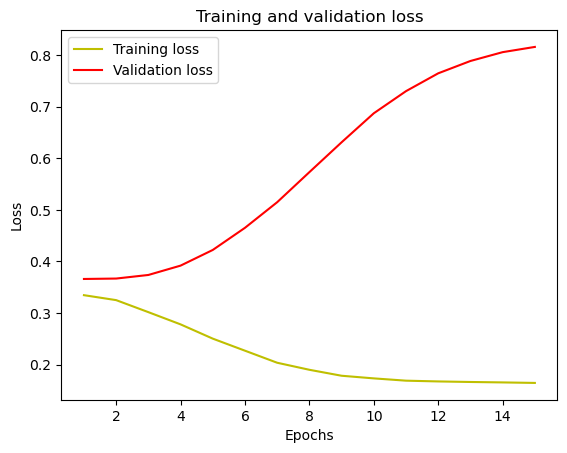

In [13]:
#plot the training and validation accuracy and loss at each epoch
history = hist
print(hist.history)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

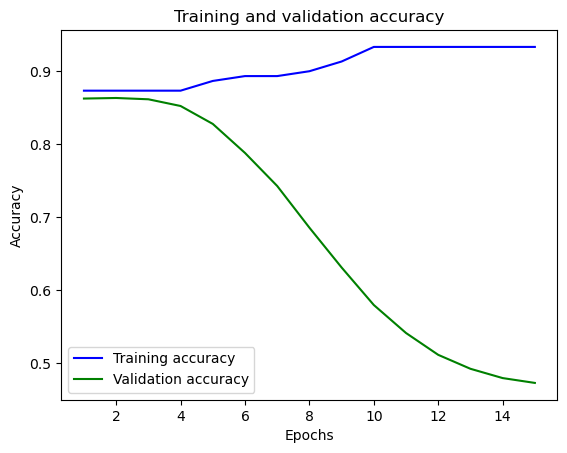

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy at each epoch
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
testx_flat = np.array(testx).reshape(-1, 1, 1, 3)
testy_flat = np.array(testy).reshape(-1, 1, 1, 1)

loss, accuracy = model.evaluate(testx_flat, testy_flat)

print("Model Accuracy: {}".format(accuracy * 100))


19200/19200 [==============================] - 56s 3ms/step - loss: 0.8897 - accuracy: 0.4253
Model Accuracy: 42.52978563308716


In [16]:
# All training images
sum_iou=0
i = 0
for i in range(len(trainx)):
    test_img = trainx[i]
    ground_truth=trainy[i]

    prediction = model.predict(test_img.reshape(-1, 1, 1, 3))
    prediction = tf.where(prediction >= 0.3, 0, 1)

    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/x_train.shape[0]
print("Mean IoU: ", m_iou_simple)

32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.015165775
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.4086914
32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.49267578
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.11767578
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.1459961
32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.10839844
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.114746094
32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.21875
32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.28466797
32/32 [==============================] - 0s 4ms/step
IoU for the current prediction = 0.42578125
32/32 [==========================

In [17]:
len(trainx)

2000

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


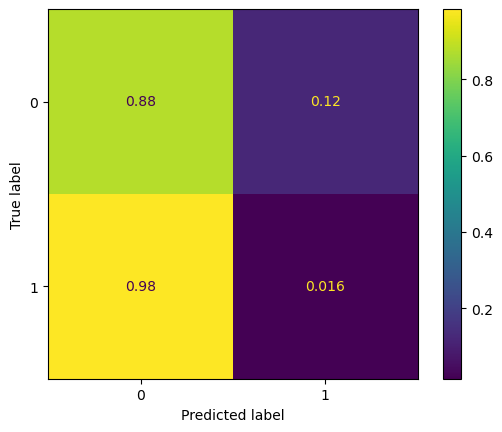

In [18]:
# For all train images
from sklearn.metrics import confusion_matrix

pred_train_array = []
for i in range(len(trainx)):
    img = model.predict(trainx[i].reshape(-1, 1, 1, 3))
    pred_train_array.append(tf.where(img >= 0.3, 0, 1))

flat_truth_arr = trainy.flatten()

flat_preds_arr = np.array(pred_train_array).flatten()
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

In [19]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [20]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

True Positive Rate(TPR):  0.01611882421490426
False Positive Rate(FPR):  0.12430356545393713
True Negative Rate(TNR):  0.9838811757850957
False Negative Rate(FNR):  0.8756964345460628


In [21]:
print("F1 score of the predictions: ",f1_score(flat_truth_arr, flat_preds_arr, average='macro'))

F1 score of the predictions:  0.4249314326076723


In [22]:
# All test images
sum_iou=0
i = 0
for i in range(len(testx)):
    test_img = testx[i]
    ground_truth=testy[i]

    prediction = model.predict(test_img.reshape(-1, 1, 1, 3))
    prediction = tf.where(prediction >= 0.3, 0, 1)

    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/testx.shape[0]
print("Mean IoU: ", m_iou_simple)

32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.2631836
32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.47314453
32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.36279297
32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.4267578
32/32 [==============================] - 0s 3ms/step
IoU for the current prediction = 0.44140625
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.24658203
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.45996094
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.37597656
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.36035156
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.20947266
32/32 [=========================

In [26]:
print(testx.shape)
# For all test images
pred_test_array = []
for i in range(testx.shape[0]):
    img = model.predict(testx[i].reshape(-1, 1, 1, 3))
    pred_train_array.append(tf.where(img >= 0.3, 0, 1))

flat_truth_arr = testy.flatten()


flat_preds_arr = np.array(pred_test_array).flatten()
print(flat_preds_arr.shape, )
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

(600, 32, 32, 3)
32/32 [==============================] - 0s 3ms/step


ValueError: Found input variables with inconsistent numbers of samples: [614400, 0]

In [27]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [28]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

True Positive Rate(TPR):  0.01611882421490426
False Positive Rate(FPR):  0.12430356545393713
True Negative Rate(TNR):  0.9838811757850957
False Negative Rate(FNR):  0.8756964345460628


In [ ]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

Visualization

In [34]:
viz_test_image = testx_flat[:32 * 32]
predicted_output_image = model.predict(viz_test_image)

 1/32 [..............................] - ETA: 1s

32/32 [==============================] - 0s 3ms/step


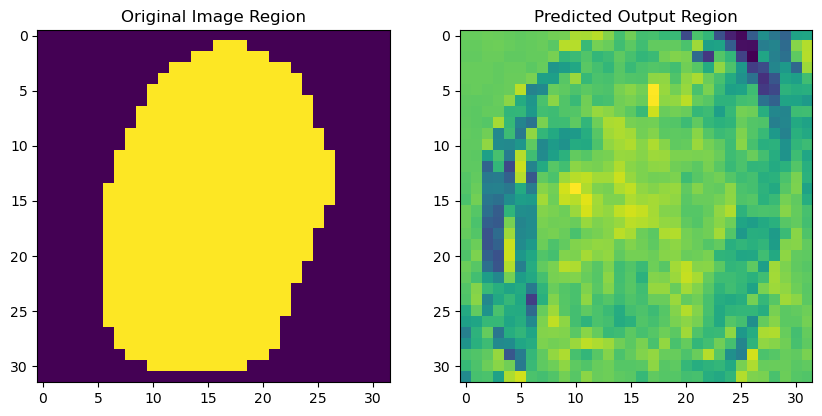

In [35]:
predicted_output_image = predicted_output_image.reshape(32, 32, 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:32*32]).reshape(32, 32, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image)
plt.title('Predicted Output Region')

plt.show()

In [41]:
viz_test_image = testx_flat[32*32:32 * 32*2]
predicted_output_image = model.predict(viz_test_image)

32/32 [==============================] - 0s 3ms/step


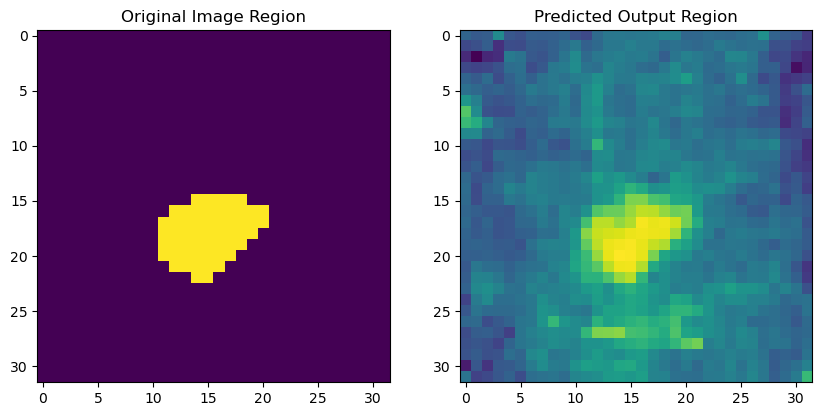

In [43]:
predicted_output_image = predicted_output_image.reshape(32, 32, 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[32*32:32*32*2]).reshape(32, 32, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image)
plt.title('Predicted Output Region')

plt.show()

In [45]:
viz_test_image = testx_flat[32*32*2:32 * 32*3]
predicted_output_image = model.predict(viz_test_image)

32/32 [==============================] - 0s 3ms/step


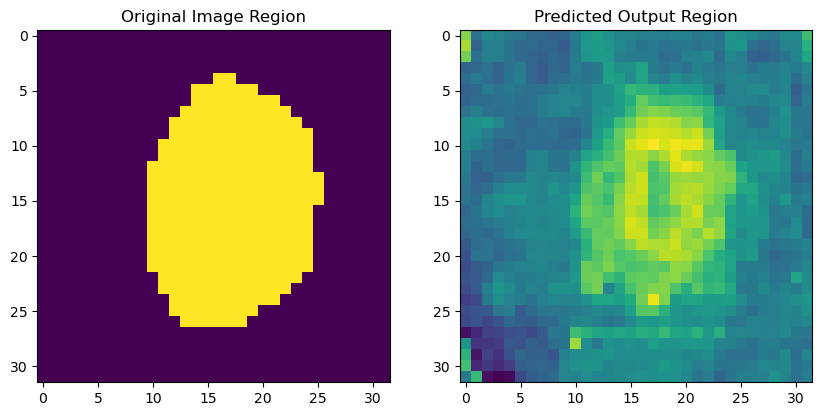

In [46]:
predicted_output_image = predicted_output_image.reshape(32, 32, 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[32*32*2:32*32*3]).reshape(32, 32, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image)
plt.title('Predicted Output Region')

plt.show()

32/32 [==============================] - 0s 3ms/step


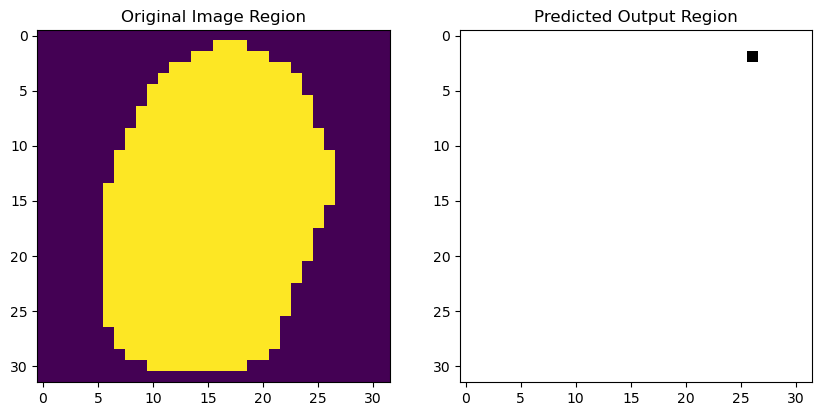

tf.Tensor(
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]], shape=(32, 32), dtype=int32)


In [40]:
viz_test_image = testx_flat[:32 * 32]
predicted_output_image = model.predict(viz_test_image)

predicted_output_image = predicted_output_image.reshape(32, 32, 1)

condition = tf.reduce_all(predicted_output_image > 0.49, axis=-1)
predicted_output_image = tf.where(condition, 255, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:32*32]).reshape(32, 32, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image, cmap='gray')
plt.title('Predicted Output Region')

plt.show()

print(predicted_output_image)